In [1]:
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import tifffile as tf
import sys
import numpy as np
import cv2
import os
import pyarrow.parquet as pq
import xml.etree.ElementTree as ET

# Load data

In [3]:
def load_xenium(sample_dir, library_id='Xenium', imgkey='dapi'):
    """
    Load Xenium data. 
    
    Args:
        sample_dir (str): A string indicating the path to the directory containing the Xenium data.
        library_id (str, optional): The library ID. Defaults to 'Xenium'.
        imgkey (str, optional): The image key. Defaults to 'dapi'.
        
    Returns:
        An AnnData object containing the preprocessed Xenium data.
        
    Raises:
        ValueError: If the required files are not found in the given path.
    """
    
    try:
        adata = sc.read(sample_dir + '/cell_feature_matrix/matrix.mtx.gz').T
        genes = pd.read_csv(sample_dir + '/cell_feature_matrix/features.tsv.gz', header=None, sep='\t')
        barcodes = pd.read_csv(sample_dir + '/cell_feature_matrix/barcodes.tsv.gz', header=None)[0].values
        df_cell = pd.read_csv(sample_dir + '/cells.csv.gz', header = 0, index_col = 0)
    except FileNotFoundError:
        raise ValueError("The required files are not found in the given path.")
    
    df_cell.index = df_cell.index.astype('str')
    
    adata.var_names = genes[1].values  # var_names : Gene Symbol
    adata.obs = df_cell  # obs

    adata.var['gene_ids'] = genes[0].values
    adata.var['gene_type'] = genes[2].values #gene types; to remove controls

    adata.uns["spatial"] = dict()
    adata.uns["spatial"][library_id] = dict()
    adata.obsm['spatial'] = adata.obs[['x_centroid', 'y_centroid']].to_numpy()
    adata.uns["spatial"][library_id]['images'] = dict()
    adata.uns["spatial"][library_id]['scalefactors'] = {f"tissue_{imgkey}_scalef": 1,
                                                         'spot_diameter_fullres': 1}

    adata.obs['center_x'] = adata.obs['x_centroid']
    adata.obs['center_y'] = adata.obs['y_centroid']
    adata.obs['barcode'] = adata.obs.index
    
    # Remove blank genes : 'Negative Control Codeword', 'Negative Control Probe'
    keep = adata.var['gene_type'] == 'Gene Expression'
    adata = adata[:,keep]
    print("Remove Blank gene.")


    mipurl = os.path.join(sample_dir, 'morphology_mip.ome.tif')

    with tf.TiffFile(mipurl) as tif:
        for tag in tif.pages[0].tags.values():
            if tag.name == 'ImageDescription':
                tag_val = tag.value

    root = ET.fromstring(tag_val)
    namespace = {'ns': 'http://www.openmicroscopy.org/Schemas/OME/2016-06'}
    pixels_element = root.find(".//ns:Pixels", namespace)

    # Check if the 'Pixels' element is found
    if pixels_element is not None:
        adata.uns["spatial"][library_id]['PhysicalSize'] = float(pixels_element.get("PhysicalSizeX"))
        size_x = int(pixels_element.get("SizeX"))
        size_y = int(pixels_element.get("SizeY"))
        adata.uns["spatial"][library_id]['DAPI_size'] = (size_x, size_y)
    else:
        raise ValueError("Error: 'Pixels' element not found.")
    
    print("Preprocessing Complete.")
    return adata

In [4]:
adata = load_xenium('/storage/public/Xenium_V1_hColon_Cancer_Add_on_FFPE/Xenium/')

Remove Blank gene.
Preprocessing Complete.


# Resize H&E image
in order to apply cv2 affine transformation

In [5]:
def img_resize(img,scale_factor):
    width = int(np.floor(img.shape[1] * scale_factor))
    height = int(np.floor(img.shape[0] * scale_factor))
    return cv2.resize(img, (width, height), interpolation = cv2.INTER_AREA)

def write_ome_tif(filename, image, channel_names, photometric_interp, metadata, subresolutions = 7):
    subresolutions = subresolutions

    fn = filename + ".ome.tif"
    with tf.TiffWriter(fn,  bigtiff=True) as tif:
        pixelsize = metadata['PhysicalSizeX']

        options = dict(
            photometric=photometric_interp,
            tile=(1024, 1024),
            dtype=image.dtype,
            compression='jpeg2000',
            resolutionunit='CENTIMETER'
        )

        print("Writing pyramid level 0")
        tif.write(
            image,
            subifds=subresolutions,
            resolution=(1e4 / pixelsize, 1e4 / pixelsize),
            metadata=metadata,
            **options
        )

        scale = 1
        for i in range(subresolutions):
            scale /= 2
            downsample = img_resize(np.moveaxis(image,0,-1),scale)
            print("Writing pyramid level {}".format(i+1))
            tif.write(
                np.moveaxis(downsample,-1,0),
                subfiletype=1,
                resolution=(1e4 / scale / pixelsize, 1e4 / scale / pixelsize),
                **options
            )

In [6]:
with tf.TiffFile('/storage/public/Xenium_V1_hColon_Cancer_Add_on_FFPE/he_image/Xenium_V1_hColon_Cancer_Add_on_FFPE_he_image.ome.tif') as tif:
    image = tif.asarray()
    image = cv2.resize(image, (image.shape[1] // 4, image.shape[0] // 4))
    
    if image.shape[-1] < image.shape[0]:
        image = np.moveaxis(image,-1,0)
    
    if tif.is_ome:
        meta = tf.xml2dict(tif.ome_metadata)
    
    if tif.pages[0].photometric == 2:
        photometric_interp='rgb'
        channel_names=None
    
    else:
        photometric_interp='minisblack'
        channel_names=[]
        for i, element in enumerate(meta['OME']['Image']['Pixels']['Channel']):
            channel_names.append(meta['OME']['Image']['Pixels']['Channel'][i]['Name'])

    metadata={
        'PhysicalSizeX': meta['OME']['Image']['Pixels']['PhysicalSizeX'],
        'PhysicalSizeXUnit': meta['OME']['Image']['Pixels']['PhysicalSizeXUnit'],
        'PhysicalSizeY': meta['OME']['Image']['Pixels']['PhysicalSizeY'],
        'PhysicalSizeYUnit': meta['OME']['Image']['Pixels']['PhysicalSizeYUnit'],
        'Channel': {'Name': channel_names}
        }

# Load transform matrix and warpAffine

### Load transform matrix from xenium explorer

In [7]:
he_image = np.moveaxis(image ,0, 2)
transform_matrix = np.array(pd.read_csv('/storage/public/Xenium_V1_hColon_Cancer_Add_on_FFPE/he_image/resized_image_alignment.csv',
                                    index_col=None, header=None))[:2, :]

assert transform_matrix.shape == (2, 3), "The shape of transform_matrix should be (2, 3)"

transformed_image = cv2.warpAffine(he_image, M=transform_matrix, 
                                   dsize=adata.uns['spatial']['Xenium']['DAPI_size'])

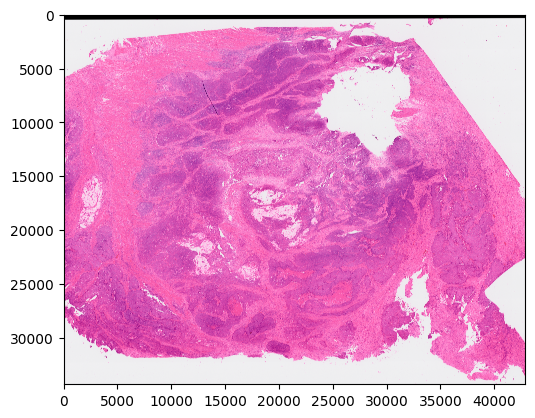

In [8]:
plt.imshow(transformed_image)

In [9]:
transformed_image.shape

(34338, 42905, 3)

### resize image and put into anndata

In [10]:
target_size = 2000

In [11]:
aspect_ratio = transformed_image.shape[1] / transformed_image.shape[0]

In [12]:
hires_image = cv2.resize(transformed_image, dsize = (target_size, int(target_size / aspect_ratio)))

(1600, 2000, 3)


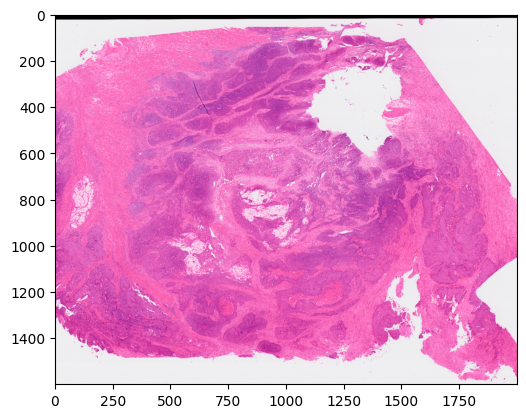

In [13]:
plt.imshow(hires_image)
print(hires_image.shape)

In [14]:
tissue_hires_scalef = target_size / 42905 / adata.uns['spatial']['Xenium']['PhysicalSize']
adata.uns['spatial']['Xenium']['scalefactors']['tissue_hires_scalef'] = tissue_hires_scalef

xmin, xmax = adata.obs['x_centroid'].min(), adata.obs['x_centroid'].max()
ymin, ymax = adata.obs['y_centroid'].min(), adata.obs['y_centroid'].max()

hires_image[:round(ymin * tissue_hires_scalef), :,:] = 0
hires_image[round(ymax * tissue_hires_scalef):, :,:] = 0
hires_image[:, :round(xmin * tissue_hires_scalef),:] = 0
hires_image[:, round(xmax * tissue_hires_scalef):,:] = 0

hires_image = hires_image.astype('float32')
hires_image = hires_image / 255
adata.uns['spatial']['Xenium']['images']['hires'] = hires_image

In [15]:
adata.uns['spatial']['Xenium']['DAPI_size'] = list(adata.uns['spatial']['Xenium']['DAPI_size'])

### Add Cell type prediction

In [2]:
import scanpy as sc

In [16]:
import tacco as tc

In [20]:
ref = sc.read_h5ad('./GSE178341.h5ad')

In [27]:
tc.tl.annotate(adata, 
               ref, 
               annotation_key='celltype',
               result_key='celltype')


Starting preprocessing
Annotation profiles were not found in `reference.varm["celltype"]`. Constructing reference profiles with `tacco.preprocessing.construct_reference_profiles` and default arguments...
Finished preprocessing in 192.03 seconds.
Starting annotation of data with shape (587000, 418) and a reference of shape (370055, 418) using the following wrapped method:
+- platform normalization: platform_iterations=0, gene_keys=celltype, normalize_to=adata
   +- multi center: multi_center=None multi_center_amplitudes=True
      +- bisection boost: bisections=4, bisection_divisor=3
         +- core: method=OT annotation_prior=None
mean,std( rescaling(gene) )  2.381709592415577 6.880206008637397
bisection run on 1
sparse_dot_mkl is not found, so a (slower) fallback is used.
bisection run on 0.6666666666666667
sparse_dot_mkl is not found, so a (slower) fallback is used.
bisection run on 0.4444444444444444
sparse_dot_mkl is not found, so a (slower) fallback is used.
bisection run on 0.29

AnnData object with n_obs × n_vars = 587115 × 425
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'center_x', 'center_y', 'barcode'
    var: 'gene_ids', 'gene_type'
    uns: 'spatial'
    obsm: 'spatial', 'celltype'
    varm: 'celltype'

# Export

In [39]:
adata.obs[[f'celltype_{x}' for x in adata.obsm['celltype'].columns.values]] = adata.obsm['celltype']

In [41]:
adata.write_h5ad('./IAMSAM/data/Xenium_V1_hColon_Cancer_Add_on_FFPE.h5ad')